In [1]:
%reset -f
from pythonrc import *

In [2]:
time_step = 1.0

tunnel.extra_attributes['rate_limit'] = 0.1
voithschneider_port.extra_attributes['rate_limit'] = 0.1
voithschneider_starboard.extra_attributes['rate_limit'] = 0.1


actuators = [tunnel, voithschneider_port, voithschneider_starboard]
force_torque_components = [
    skadipy.allocator.ForceTorqueComponent.X,
    skadipy.allocator.ForceTorqueComponent.Y,
    skadipy.allocator.ForceTorqueComponent.N,
]

allocators = []
gamma = [1e-1, 1e-1]
mu    = [1e-1, 1e-1]
rho   = [1.0, 1.0]
lambda_p = [0.99, 0.0]


for g,m,r,l in zip(gamma, mu, rho, lambda_p):

    allocators.append(skadipy.allocator.reference_filters.MinimumMagnitudeAndAzimuth(
        actuators=actuators, force_torque_components=force_torque_components, control_barrier_function=skadipy.safety.ControlBarrierFunctionType.ABSOLUTE,
        derivative=skadipy.toolbox.derivative.ExponentialSmoothing(r=0.1),
        gamma=g, mu=m, rho=r, time_step=time_step, lambda_=l
    ))



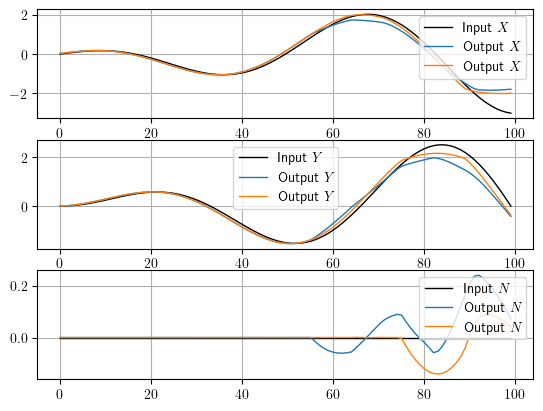

In [3]:
data = generate_spiral_dataset(
    num_points=100,
    num_turns=1.5,
    k=3,
)

tau_cmd = np.concatenate(
    (data, np.zeros((np.shape(data)[0], 4))),
    axis=1
)
d_tau_cmd = np.gradient(tau_cmd, axis=0) / time_step

xi_hist, theta_hist, tau_hist = run_tests(tau_cmd=tau_cmd, d_tau_cmd=d_tau_cmd, allocators=allocators)
plot_histories(tau_cmd=tau_cmd, tau_alloc=tau_hist)

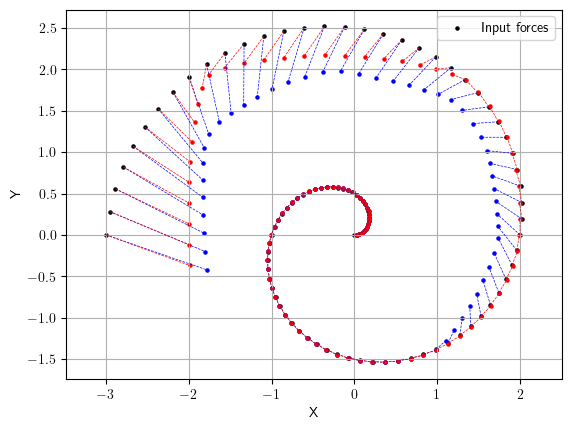

In [4]:
plot_2d_allocation(tau_cmd=tau_cmd, allocators=allocators, tau_hist=tau_hist)

plt.grid(True)
plt.axis('equal')
plt.legend()
plt.xlabel("X")
plt.ylabel("Y")
plt.show()

In [5]:
angles = []
for control_input in xi_all:
    a = np.empty((len(control_input), 2))
    for i, u in enumerate(control_input):
        a2 = np.arctan2(u[2], u[1])
        a3 = np.arctan2(u[4], u[3])
        a[i] = np.array([a3])
    angles.append(a)

for _, angle in enumerate(angles):
    angle[0:3,0] = None

plt.clf()
for _, angle in enumerate(angles):
    plt.plot(np.degrees(angle[:,0]))
    # plt.plot(np.degrees(np.unwrap(angle[:,0])))
    pass


l = []
for i in lambda_p:
    l.append(f"$\lambda = {i}$")

plt.legend(l)
# plt.plot(np.unwrap(angles[3][:,0]))
plt.grid(True)

NameError: name 'xi_all' is not defined

In [ ]:
save_mat(
    filename="data/17.mat",
    inputs=tau,
    xi=xi_all,
    thetas=theta_all,
    outputs=allocated,
    rho=rho,
    gamma=gamma,
    mu=mu,
    lambda_p=lambda_p,
    thruster=voithschneider_port
)

In [ ]:
max(max(allocated[0][:,0]), -min(allocated[0][:,0]))

In [ ]:
np.size(tau)